<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Population" data-toc-modified-id="Population-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Population</a></span></li><li><span><a href="#Covid-19" data-toc-modified-id="Covid-19-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Covid-19</a></span></li><li><span><a href="#Particulate-Matter" data-toc-modified-id="Particulate-Matter-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Particulate Matter</a></span><ul class="toc-item"><li><span><a href="#Interpolation" data-toc-modified-id="Interpolation-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Interpolation</a></span></li></ul></li></ul></li><li><span><a href="#Risk" data-toc-modified-id="Risk-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Risk</a></span></li></ul></div>

# Imports

In [655]:
import numpy as np
import xarray as xr
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interactive
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import pandas as pd
import regionmask
import matplotlib.gridspec as gridspec
import imageio
import os

from PIL import Image
sns.set('paper','dark','muted', 'sans-serif', 2, color_codes=True)

cborders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='ne_admin_0_countries',
        scale='10m',
        facecolor='none')
eu_countries = regionmask.defined_regions.natural_earth.countries_50


# Data

## Population

<IPython.core.display.Javascript object>


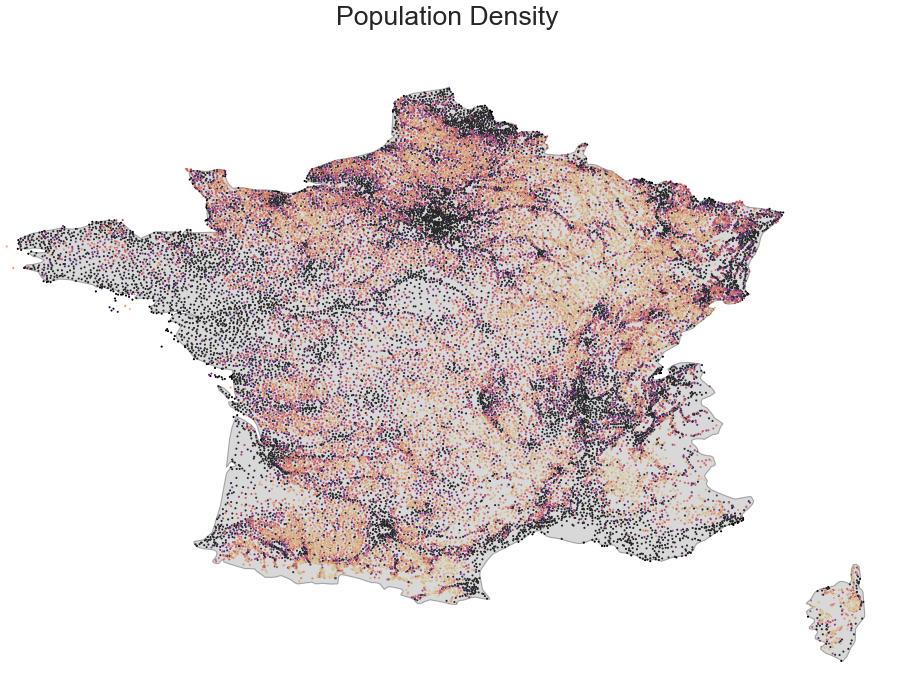

/home/nrieger/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


In [656]:
pop = pd.read_csv('./../data/pop/pop_fr.csv', usecols=[0,1,2,3,4,5,6,42])
pop.columns = ['reg', 'dep', 'com', 'article', 'com_nom', 'lon', 'lat', 'total']

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ax.set_extent([-5,10,41,52])
ax.add_geometries(eu_countries['F'].polygon, ccrs.PlateCarree(),edgecolor='black', facecolor='gray', alpha=0.3)

sc = ax.scatter(pop.lon,pop.lat,c=pop.total,s=.5, vmin=0, vmax=1000, cmap='magma_r')
#ax.scatter(dep.lon,dep.lat,c=dep.total,s=50, vmin=0, vmax=1000000, cmap='RdBu_r')
#fig.colorbar(sc,ax=ax)
ax.outline_patch.set_linewidth(0.)
fig.subplots_adjust(bottom=0.005,left=0.005,right=0.99,top=0.97)
plt.title('Population Density')
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


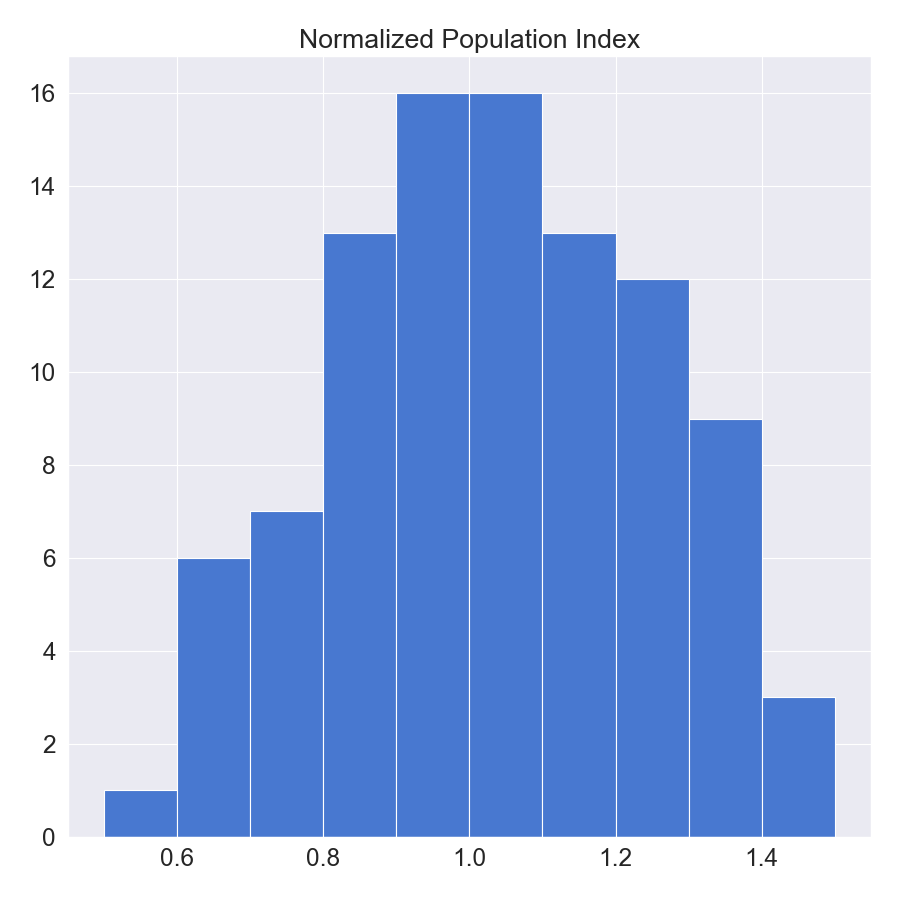

In [657]:
def normalize(x):
    return 0.5 + (x - x.min()) / (x.max() - x.min())


pop['logtotal'] = np.log10(pop['total'])
pop['totalNorm'] = normalize(pop['total'])  
pop['logtotalNorm'] = normalize(pop['logtotal'])  

popDEP = pop.copy().groupby('dep').mean()
popDEP['total'] = popfr.groupby('dep').sum()['total']
popDEP['logtotal'] = np.log10(popDEP['total'])
popDEP['totalNorm'] = normalize(popDEP['total'])
popDEP['logtotalNorm'] = normalize(popDEP['logtotal'])

plt.figure(figsize=(9,9))
popDEP.logtotalNorm.hist()
plt.title('Normalized Population Index')
plt.tight_layout()
plt.show()

## Covid-19

In [658]:
%matplotlib notebook
covid = pd.read_csv('./../data/covid/covid_fr.csv', sep=';').dropna()
covid = covid[covid.sexe==0]
covid = covid[covid['jour'] == '2020-10-14']
covid['dep'] = covid['dep'].replace({'2A':'201','2B':'202'}).astype(int)
test = pop[['dep','lon','lat']].drop_duplicates(subset=['dep'])
covid['lon'] = [test[test['dep']==int(depNum)].lon.values.squeeze() for depNum in covid['dep']]
covid['lat'] = [test[test['dep']==int(depNum)].lat.values.squeeze() for depNum in covid['dep']]
covid = covid[:-5]


#covidExtra (extrapolation of Covid data to communité level)
covidExtra = pop.copy()
covidExtra['hosp'] = [covid[covid['dep'] == depNum].hosp.values.squeeze() for depNum in covidExtra['dep']]

<IPython.core.display.Javascript object>


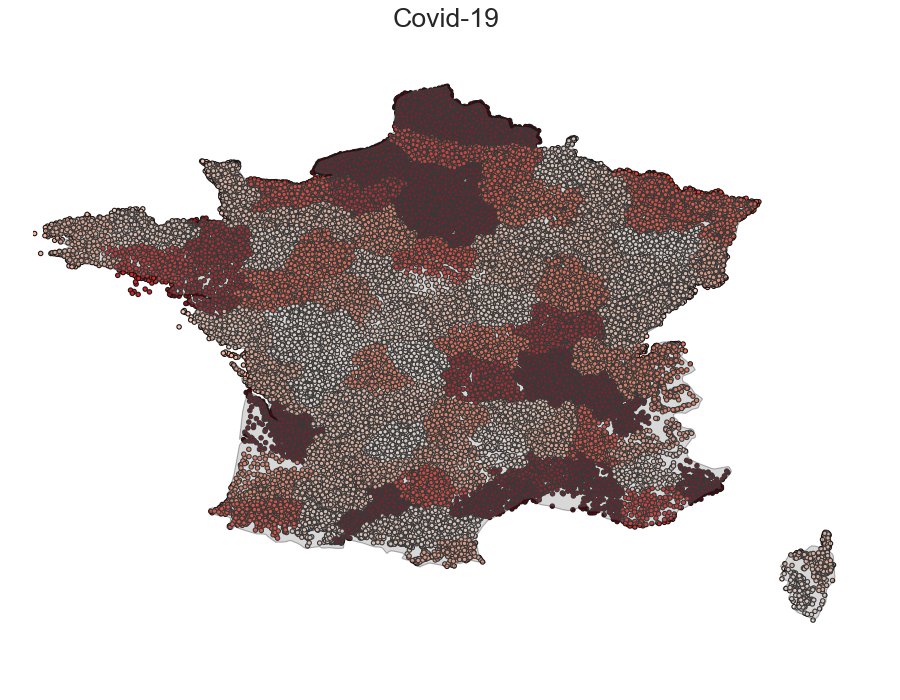

/home/nrieger/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


In [659]:
fig = plt.figure(figsize=(9,7))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#ax.coastlines('10m', lw=.5)
ax.add_geometries(eu_countries['F'].polygon, ccrs.PlateCarree(),edgecolor='black', facecolor='gray', alpha=0.3)
ax.set_extent([-5,10,40,52])
#ax.scatter(covid.lon.values,covid.lat.values,c=covid.hosp.values,s=100,edgecolor='k', vmin=0, vmax=100, cmap='Reds')
ax.scatter(covidExtra.lon.values,covidExtra.lat.values,c=covidExtra.hosp.values,s=10,edgecolor='k', vmin=0, vmax=100, cmap='Reds')

ax.set_title('Covid-19')
ax.outline_patch.set_linewidth(0.)
fig.subplots_adjust(bottom=0.005,left=0.001,right=0.99,top=0.95)

plt.tight_layout()
plt.show()


## Particulate Matter

In [660]:
pm25 = xr.open_dataset('./../data/pm/pm25.nc')
pm25 = pm25.pm2p5_conc.drop('level').squeeze() #.sortby(['longitude'])
pm25.coords['longitude'] = (pm25.coords['longitude'] + 180) % 360 - 180
pm25 = pm25.sortby('longitude')
pm25 = pm25.sel(longitude=slice(-10,10),latitude=slice(55,40))

<IPython.core.display.Javascript object>


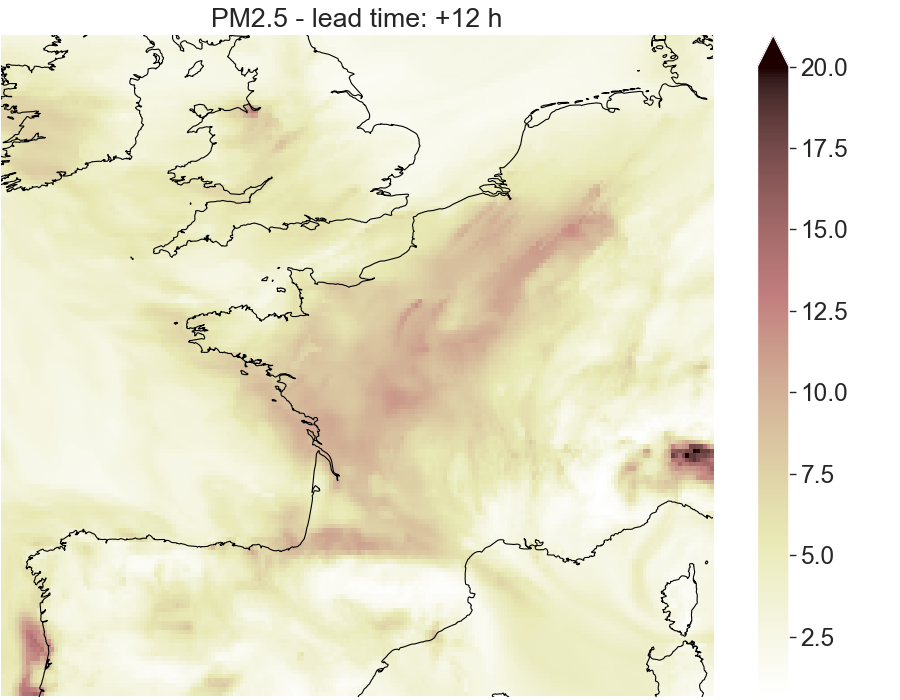

interactive(children=(IntSlider(value=0, description='time', max=96), Output()), _dom_classes=('widget-interac…

In [661]:
wtime = widgets.IntSlider(value=0,min=0,max=96)

images=[]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines('10m')
#eu_countries['F','D'].plot(ax=ax,add_label=False,resolution='10m')
#pm25[0].plot(ax=ax, vmax=15, cmap='RdBu_r')
im = pm25[0].plot.imshow(ax=ax, cmap='pink_r', vmax=20, cbar_kwargs={'label':''})
ax.set_extent([-10,10,40,55])
ax.set_title('', fontdict={'fontsize': '25',
                     'fontweight' : '3'})

ax.set_aspect('auto')
ax.outline_patch.set_linewidth(0.)
fig.subplots_adjust(bottom=0.005,left=0.001,right=0.99,top=0.95)


def plot(time):
    im.set_data(pm25[time])
    ax.set_title('PM2.5 - lead time: {:+} h'.format(time))
    images.append(im)

    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = '/home/nrieger//Transfer/workshops/2020-10 Barcelona Hackathon/data/' + str(time) + '_pm25.jpg'
    plt.savefig(filepath, dpi=120)
    
    
widgets.interactive(plot,time=wtime)

### Interpolation

In [ ]:
resolution = 10

x,y = pop.lon[::resolution], pop.lat[::resolution]

pms =[]
for i in range(0,96):
    print(100*i/96)
    pmScatter = np.array([pm25[i].interp(longitude=lon,latitude=lat).values for lon,lat in zip(x,y)])
    pmScatter = np.vstack((x,y,pmScatter)).T
    pmScatter = pd.DataFrame(pmScatter, columns=['lon','lat','pm25'])
    
    pms.append(pmScatter)

0.0
1.0416666666666667
2.0833333333333335
3.125
4.166666666666667
5.208333333333333
6.25
7.291666666666667
8.333333333333334
9.375
10.416666666666666
11.458333333333334
12.5
13.541666666666666
14.583333333333334
15.625
16.666666666666668
17.708333333333332
18.75
19.791666666666668
20.833333333333332
21.875
22.916666666666668
23.958333333333332
25.0
26.041666666666668
27.083333333333332
28.125
29.166666666666668
30.208333333333332
31.25
32.291666666666664
33.333333333333336
34.375
35.416666666666664
36.458333333333336
37.5
38.541666666666664
39.583333333333336
40.625
41.666666666666664
42.708333333333336
43.75
44.791666666666664
45.833333333333336
46.875
47.916666666666664
48.958333333333336
50.0
51.041666666666664
52.083333333333336
53.125
54.166666666666664
55.208333333333336
56.25
57.291666666666664
58.333333333333336
59.375
60.416666666666664
61.458333333333336
62.5
63.541666666666664
64.58333333333333
65.625
66.66666666666667
67.70833333333333
68.75
69.79166666666667
70.83333333333

# Risk

$$
\text{Risk} = \text{Hazard} \times \text{Vulnerability} \times \text{Exposure}
$$

In [757]:
riskMaps = []
for i in range(0,3):

    risk =  normalize(pms[i].pm25).values * pop.logtotalNorm[::resolution].values * normalize(covidExtra.hosp[::resolution])
    risk = np.vstack((x,y,risk)).T
    risk = pd.DataFrame(risk,columns=['lon','lat','risk'])
    
    riskMaps.append(risk)

<IPython.core.display.Javascript object>


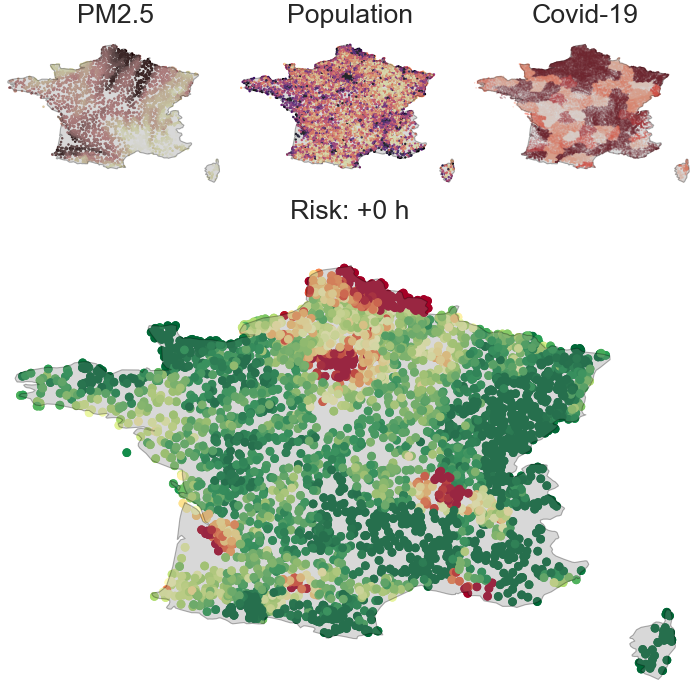

interactive(children=(IntSlider(value=0, description='time', max=2), Output()), _dom_classes=('widget-interact…

In [788]:
wtime2 = widgets.IntSlider(value=0,min=0,max=2)

fig = plt.figure(constrained_layout=True, figsize=(7,7))
gs = fig.add_gridspec(4, 3)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1:, :], projection=ccrs.PlateCarree())
axes = [ax1,ax2,ax3,ax4]

for a in axes:
    a.add_geometries(eu_countries['F'].polygon, ccrs.PlateCarree(),edgecolor='black', facecolor='gray', alpha=0.3)
    a.set_extent([-5,10,41,52])
    a.set_aspect('auto')
    a.outline_patch.set_linewidth(0.)
    pass

sc1 = ax1.scatter(pms[0].lon,pms[0].lat,c=pms[0].pm25, cmap='pink_r', s=1, vmax=10)
ax1.set_title('PM2.5')
        
ax2.scatter(pop.lon[::4],pop.lat[::4],c=pop.logtotal[::4],s=.8, vmin=2, vmax=4, cmap='magma_r')
ax2.set_title('Population')

ax3.scatter(covidExtra.lon,covidExtra.lat,c=covidExtra.hosp,s=.01, vmin=0, vmax=50, cmap='Reds')
ax3.set_title('Covid-19')

scrisk = ax4.scatter(riskMaps[0].lon,riskMaps[0].lat,c=riskMaps[0].risk, cmap='RdYlGn_r', s=30, vmin=0.4, vmax=1)
ax4.set_title('Risk')



#fig.subplots_adjust(bottom=0.005,left=0.001,right=0.99,top=0.95)


def plot(time):
    sc1.set_array(pms[time].pm25)
    ax4.scatter(riskMaps[time].lon,riskMaps[time].lat,c=riskMaps[time].risk, cmap='RdYlGn_r', s=30, vmin=0.4, vmax=1)
    ax4.set_title('Risk: {:+} h'.format(time))
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = '/home/nrieger//Transfer/workshops/2020-10 Barcelona Hackathon/data/' + str(time) + '_risk.jpg'
    fig.savefig(filepath, dpi=120)
    pass
    
widgets.interactive(plot,time=wtime2)